# Option pricing: Jump diffusion process in MCA and VFA
When pricing a derivative we usually rely on some sort of financial model, simulating the stock behaviour and from this computing the expected payoff of such a contract. In computational finance we rely on montecarlo simulation to identify such payoffs, but when the stochastic process is well defined is possible to identify the characteristic function of the process and hence compute the probability of a specific payoff. <br>
In this case we will use the jump diffusion process to simulate the stock evolution, or more specifically the Furier transform on which we will compute the option price. Using neural network we can teach the machine how to price the option based on two different approach:
1. Model Calibration Approach (MCA), on which the feature of the network are the option parameter (Time to maturity and strike/moneyness) and the underlying model parameter (ie the parameter of the model used to simulate market evolution) while the label is the option price.
2. Volatility Feature Approach (VFA), on which the feature are the option parameter and the implied volatility at different strikes (ie a volatility surface) while the label is the option price.

## Jump diffusion process
The jump diffusion processes are a family of stochastic process characterized by the sum of a brownian motion with drift and a jump process. We talk about a family since there are possibly an infinite amount of jump process to be added to the main process.
$$ Z_{t}=\int_{0}^{t}\mu (s)ds +\int_{0}^{t}\sigma (s)dW_{s} +\mathcal{J}(t)$$
The jump process are cadlag function (right continuous with existing left limit) defined as the difference between the right and the left limit at each point in time ($\Delta_{t} = J_{t}-J{t^{-}}$). The number of jumps ($N$)  can be represented as a Poisson process with intensity $\lambda\delta t$, such that the number of jumps in the interval $\delta t$ is given by 
$$\mathbb{P}(N=n)=e^{-\lambda\delta t}\frac{(\lambda\delta t)^{n}}{n!}$$
while the jump size is given by another density, $\mathbb{P}(J_{n}<x)=f_{j}(x)$. Finally we can identify 
$$ \mathcal{J}_{t}=\sum_{n=1}^{N(\lambda t)}J_{n}$$
which is the summation of the jump width (following $f_{j}$) from the start to the process till now ($t$), where the number of jump follow a poisson process with intensity $\lambda t$. <br>

There are several possible law describing the jump width, for our aim we will exploit the binomial model and the Merton model (normal jump). <br>
## Packages and function
Before proceeding import all necessary package and define the function that will be used in htis notebook.


In [1]:
import warnings
import sys
import math
import time
import pandas            as pd
import numpy as np
from keras.models import Sequential   
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility  #external library used to compute implied volatility 
from Lib.FT_opt import ft_opt  #Fourier Transform method to compute option price
from Lib.jumps import jmp_binary,jmp_normal #two kind of jump process
from scipy.stats             import norm, gaussian_kde
import scipy as sp
from smt.sampling_methods import LHS
import time as t
warnings.filterwarnings('ignore')


Using TensorFlow backend.


In [2]:
def lhs_sampling(rand, NUM, bounds=None): #num is number of observation in the sample

    mInt = 2**15
    MInt = 2**16
    # remember that the result of apply the function list to
    # a python dictionary is a list containing dict's keys
    kw   = list(bounds)
    # builds the array of bounds
    limits = np.empty(shape=(0,2))
    for k in kw:
        limits = np.concatenate((limits, [bounds[k]]), axis=0)
    sampling = LHS(xlimits=limits, random_state=rand.randint(mInt,MInt))
    x        = sampling(NUM)
    X = pd.DataFrame()
    for n in range(len(kw)):
        tag    = kw[n]
        X[tag] = x[:,n]
    return X

class Timer:
    def __init__(self):
        self.t0 = t.time()
    def timer(self):
        print("Elapsed %.5f s"%(t.time()-self.t0))

def show_scattered( y, t, TAG, ax = None):
    xMin = min(t)
    xMax = max(t)
    v    = np.arange(xMin, xMax, (xMax-xMin)/100.)

    diff   = np.fabs(y - t)
    print("@ %-24s: E[y-t]: %.6f Std(y-t): %.6f" %( TAG, np.mean(diff), np.std(diff)))
    if ax == None: return

    ax.plot( y, t, ".")
    ax.plot( v, v, color="red")
    ax.set_title("%s mae=%8.4f, std=%8.4f" %(TAG, np.mean(diff), np.std(diff)))
    ax.set_xlabel("predicted")
    ax.set_ylabel("target")


def display_nn_results(model, X_train, X_test, t_train, t_test, resFile=None):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle("Scattered plots")
    #
    # The numpy module ravel of NumPy provides a function, called numpy.ravel, which is used to change
    # a 2-dimensional array or a multi-dimensional array into a contiguous flattened array. The returned
    # array has the same data type as the source array or input array.
    #
    y_train = np.ravel(model.predict(X_train))
    show_scattered(y_train, t_train, "InSample", ax=ax[0])
    diff = np.fabs(y_train - t_train)
    delta = y_train - t_train
    RES = pd.DataFrame({"predicted": y_train, "target": t_train, "err": diff, "delta": delta})
    h1 = RES['delta']
    RES.to_csv("res_in_sample.csv", sep=',', float_format="%.6f", index=True)
    print("@")
    y_test = np.ravel(model.predict(X_test))
    show_scattered(y_test, t_test, "OutOfSample", ax=ax[1])
    diff = np.fabs(y_test - t_test)
    delta = y_test - t_test
    RES = pd.DataFrame({"predicted": y_test, "target": t_test, "err": diff, "delta": delta})
    h2 = RES['delta']
    RES.to_csv("res_ou_sample.csv", sep=',', float_format="%.6f", index=True)
    print("@")
    if resFile != None:
        plt.savefig(resFile, format="png")
        print("@ %-12s: results saved to '%s' " % ("Info", resFile))
    plt.show()
    score = model.evaluate(X_test, t_test, verbose=1)
    print("%s = %f ; %s = %f"%(model.metrics_names[0],model.evaluate(X_test,t_test)[0],model.metrics_names[1],model.evaluate(X_test,t_test)[1]))
    h1.plot(kind='hist', bins=100, grid=False, figsize=(12, 5), color='blue',label='In sample error')
    h2.plot(kind='hist', bins=100, grid=False, figsize=(12, 5), color='red',label='Out of sample error')
    plt.title('Error distribution')
    plt.legend()
    plt.show()

def histo_array(keys, x, title="None"):
    LEN = len(keys)
    fig, ax = plt.subplots(1,LEN, figsize=(12,4))
    if not title == None: fig.suptitle(title)
    for n in range(LEN):
        k     = keys[n]
        lo   = np.min(x[k])
        hi   = np.max(x[k])
        bins = np.arange(lo, hi, (hi-lo)/100.)
        ax[n].hist(x[k], density=True, facecolor='g', bins=bins)
        ax[n].set_title(k)
        n += 1
    plt.subplots_adjust(left=.05, right=.95, bottom=.10, top=.80, wspace=.50)
    plt.show()

def show_smiles(smiles=None):
    fig, ax = plt.subplots(1,1, figsize=(12,12))
    fig.suptitle("Sample smiles")
    ll = list(smiles.keys())
    ll.sort()
    for t in ll:
        smile = smiles[t]
        ax.plot( smile[:,0], smile[:,1], label = "T=%5.3f" %(t))
    ax.set_title("Sample smiles")
    ax.set_xlabel("Strike")
    ax.set_ylabel("Imp Vol")

    plt.subplots_adjust(left=.10, right=0.7)
    plt.legend(title='Smiles', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def smiles_select(strikes, X, NUMSMILES=1):
    smiles  = {}
    ns = NUMSMILES
    N  = len(X["T"])
    for n in range(0,N,int(N/NUMSMILES)):
        smile = np.ndarray(shape=(len(strikes),2), dtype=np.double)
        for j in range(len(strikes)):
            k = strikes[j]
            tag = str(k)
            smile[j,0] = k
            smile[j,1] = X[tag][n]
        T         = X["T"][n]
        smiles[T] = smile
        ns -= 1
        if ns == 0: break

    return smiles

def histo_dict(df, TAG = '0000'):
    keys = list(df.keys())
    LEN = len(keys)
    fig, ax = plt.subplots(1,LEN, figsize=(12,6))
    for n in range(LEN):
        k     = keys[n]
        x     = df[k]
        lo   = np.min(x)
        hi   = np.max(x)
        bins = np.arange(lo, hi, (hi-lo)/100.)
        ax[n].hist(x, density=True, facecolor='g', bins=bins)
        ax[n].set_title("%s (len=%d)" %(k,len(x)))
        n += 1   
    plt.show()

## Model Calibration Approach
### Data generation
The following function will produce a simulation of the market. It start identifying the bound in which the latin hypercube sampling will operate. Across all the jump diffusion process two parameters are shared, the lambda and the sigma, for the purpuse of this notebook we will also identify the bound for the moneyness and the time to maturity. Referring to the single model, for the Merton jump we specify two additional parameter $m$ and $\eta$ which are the mean and standard deviation of the normal jump density, while for the binary case we have to specify the possible jump size both in the up and down movement, and then the porbability of observing an up movement (and hence the probability of obtaining a down movement). <br>
Once the data are sampled we can compute the option price of every parameter case (row of the dataframe) using the Fourier Transform method, and hence finalizing the dataset that will be fed to the neural network.

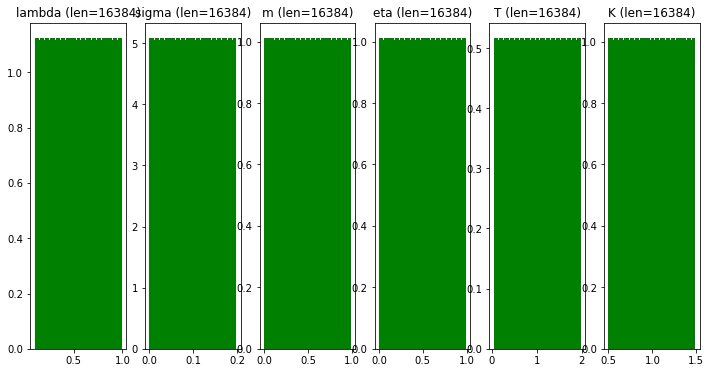

Elapsed 150.00665 s


,lambda,sigma,m,eta,T,K,P
0,0.739542,0.178593,0.619354,0.505219,1.002844,0.955048,0.333629
1,0.801999,0.041975,0.359833,0.252289,1.493504,1.432770,0.558971
2,0.447580,0.107733,0.474091,0.081635,0.790923,0.700226,0.001625
3,0.643576,0.188334,0.430817,0.810760,0.787457,0.691193,0.122113
4,0.865005,0.192476,0.380035,0.301056,1.122013,0.871796,0.153083


In [4]:
def model_generator(name:str,bound,Num,rand,xc):
    tim = Timer()
    data = lhs_sampling(rand, Num, bound)
    histo_dict(data)
    pricer = np.ndarray((Num,1))
    if name == 'J_normal':
        for i in range(Num):
            pricer[i] = ft_opt(
                jmp_normal(lmbda=data['lambda'].tolist()[i],sigma=data['sigma'].tolist()[i],m=data['m'].tolist()[i],eta=data['eta'].tolist()[i]),
                data['K'].tolist()[i],
                data['T'].tolist()[i], xc)['put']
        data['P'] = pricer
        tim.timer()
        return Num, data
    elif name == 'J_bin': 
        for i in range(Num):
            pricer[i] = ft_opt(
                jmp_binary(lmbda=data['lambda'].tolist()[i],sigma=data['sigma'].tolist()[i],pi=data['pi'].tolist()[i],u=data['u'].tolist()[i],d=data['d'].tolist()[i]),
                data['K'].tolist()[i],
                data['T'].tolist()[i], xc)['put']
        data['P'] = pricer
        tim.timer()
        return Num, data
    else:
        tim.timer()
        pass
    
rand = np.random.RandomState(42)
method = 'J_normal'
bound_norm = {'lambda': [0.1, 1],
                 'sigma': [0.001, +0.2],
                 'm':[0,1],
                 'eta':[0,1],
                 'T': [1 / 24, 2],
                 'K': [0.5, 1.5]
                 }

'''bound_bern = {'lambda': [0.1, 1],
                 'sigma': [0.001, +0.2],
                 'pi':[0,1],
                 'u':[0,1],
                 'd':[0,1],
                 'T': [1 / 12, 2],
                 'K': [0.5, 1.5]
                 }
                 #for binomial jump'''

Num,data = model_generator(method,bound_norm,2**14,rand,10)
data.head()

The previous function not only define the uniform space of parameter but also price the option using the Fourier transform method, the for cycle use each row of the dataframe to compute the price. <br>
Now we can start preprocessing the dataset, the *add_noise* function will add some noise to the label of the train set while the *preprocessing* function itself will split the dataframe and if required scale the data. Since we are producing random parameter in some case the Fourier method will produce irrealistic price (negative value or below intrinsic value) so we need to drop this case, since the same function will be used in the VFA we drop the nan computed when such irrealistic price show up.

In [5]:
def add_noise(eps,Y):
    yl = min(Y)
    yh = max(Y)
    xi = np.random.normal(loc=0,scale =eps*(max(Y)-min(Y)),size=len(Y))
    return Y

def preprocessing(data,seed,size,scaling=True,eps=0):
    data = data[data['P'] > 0]
    data = data.dropna(axis=0)
    X_train, X_test = train_test_split(data, test_size=size, random_state=seed)
    if eps>0:
            Y_train = add_noise(eps,X_train['P'])
            histo_dict( {"Train"    : np.array(X_train['P']), 
                 "Test"     : np.array(X_test["P"]), 
                 "Train Perturbed": np.array(Y_train) })
    else:
        Y_train = X_train['P']
    Y_test = X_test['P']
    X_train = X_train.drop(['P'], axis=1)
    X_test = X_test.drop(['P'], axis=1)
    if scaling:
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        scaler = StandardScaler().fit(X_test)
        X_test = scaler.transform(X_test)

        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)
    print(X_train,Y_train)
    
    return X_train, X_test, Y_train, Y_test

In [6]:
seed = np.random.RandomState().seed(42)
size = .25
X_train, X_test, Y_train, Y_test = preprocessing(data,seed,size,True,eps=0)

              0         1         2         3         4         5
0     -1.111055  1.597773 -1.417771 -0.298616 -0.886895  0.910266
1      0.421959 -0.318808 -0.400729  1.485550 -0.488660  0.488899
2     -0.413616  1.658295 -0.981320  0.980569 -1.429113 -0.993105
3     -0.601811  1.339393 -0.410480  0.874659 -0.503928  1.213123
4     -1.381413 -1.641603 -1.645853 -0.795123 -0.281697 -0.810244
...         ...       ...       ...       ...       ...       ...
12206  1.114962  0.475165  0.246422  1.427934 -0.489084  1.009873
12207 -1.421333 -1.453056  0.220561  0.320536  1.309544 -1.297024
12208 -0.066798  0.543727  1.183763  1.086691 -1.260107 -0.796014
12209 -1.491246  1.057948  1.256681  1.441067  0.597684 -1.240531
12210  0.644581  1.627187 -1.632923 -1.265365 -1.613386  0.576400

[12211 rows x 6 columns] 13561    0.290001
7243     0.515614
10878    0.006187
11899    0.532219
11737    0.002525
           ...   
6854     0.755107
16086    0.004864
12773    0.079883
239      0.089005
68

### Neural network construction
Now we can proceed building our feedforward neural network. It is a sequential model using a rectified linear unit as activation function, each layer is composed by 200 neurons except to the output layer which produce a single output (the option price). The input layer will have shape equal to the number of feature in a tuple format (eg 6 feature implies an imput shape of (6,) for the tensor). <br>
The "compile" method of the sequential class is used to define the loss function, mean squared error ($\frac{1}{N}\sum_{n=1}^{N}(y_{n}-\hat{y}_{n})^{2}$); the optimizer, root mean squared propagation algorithm (adapt descent step size based on decaying average of partial gradient); and the metric used to evaluate the model, mean absolute error ($\frac{1}{N}\sum_{n=1}^{N}|y_{n}-\hat{y}_{n}|$).

In [7]:
def NN_builder(inp_shape,num):      #input shape has value equal to the number of parameter that we will plug eg BS use 3 parameter, input shape=3
    mdl = Sequential(name="MCA_Option_%s_%d"%(method,num))
    mdl.add(Dense(200, activation='relu', input_shape=inp_shape,name='Input_layer'))  #rectified linear unit activation function, 200 neuron for each layer and 1 neuron(price) for the output layer
    mdl.add(Dense(200, activation='relu',name="Hidden_1"))
    mdl.add(Dense(200, activation='relu',name='Hidden_2'))
    mdl.add(Dense(200, activation='relu',name='Hidden_3'))
    mdl.add(Dense(1,name='Price_output'))
    mdl.summary()
    mdl.get_config()
    mdl.compile(loss='mse', optimizer='rmsprop', metrics=['mae']) #loss function used is the mean squared error (squred residual), bacward propagation is done thorough RSM prop and the analyzed metric is the mean absolute error
    return mdl

def NN_Train(model,Xtrain,Ytrain,epoch=50):
    history = model.fit(Xtrain,Ytrain,validation_split=.33,epochs=epoch,verbose=1)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.xlabel('epoch')
    plt.legend(['train','validation'])
    plt.show()

In [8]:
Model = NN_builder((X_train.shape[1],),Num)

Model: "MCA_Option_J_normal_16384"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Dense)          (None, 200)               1400      
_________________________________________________________________
Hidden_1 (Dense)             (None, 200)               40200     
_________________________________________________________________
Hidden_2 (Dense)             (None, 200)               40200     
_________________________________________________________________
Hidden_3 (Dense)             (None, 200)               40200     
_________________________________________________________________
Price_output (Dense)         (None, 1)                 201       
Total params: 122,201
Trainable params: 122,201
Non-trainable params: 0
_________________________________________________________________


### Training
Once the model is compiled we need to train it, we can split further the train set, obtainig the validation set, dividing the whole dataset in three subsets: train 50% - validation 25% - test 25%. We will use automatic batch size (32) and 50 epochs to train the network. <br>
Here we will also plot the evolution of the mean absolute error over the epochs.

Train on 8181 samples, validate on 4030 samples
Epoch 1/50
8181/8181 [==============================] - 5s 579us/step - loss: 0.0055 - mae: 0.0485 - val_loss: 0.0020 - val_mae: 0.0332
Epoch 2/50
8181/8181 [==============================] - 4s 469us/step - loss: 0.0013 - mae: 0.0254 - val_loss: 8.1654e-04 - val_mae: 0.0218
Epoch 3/50
8181/8181 [==============================] - 3s 427us/step - loss: 9.1261e-04 - mae: 0.0216 - val_loss: 0.0025 - val_mae: 0.0399
Epoch 4/50
8181/8181 [==============================] - 3s 424us/step - loss: 7.2019e-04 - mae: 0.0185 - val_loss: 3.6078e-04 - val_mae: 0.0124
Epoch 5/50
8181/8181 [==============================] - 3s 424us/step - loss: 5.9878e-04 - mae: 0.0171 - val_loss: 2.8736e-04 - val_mae: 0.0106
Epoch 6/50
8181/8181 [==============================] - 3s 427us/step - loss: 5.1901e-04 - mae: 0.0156 - val_loss: 5.9755e-04 - val_mae: 0.0193
Epoch 7/50
8181/8181 [==============================] - 4s 440us/step - loss: 4.3879e-04 - mae: 0.0147 -

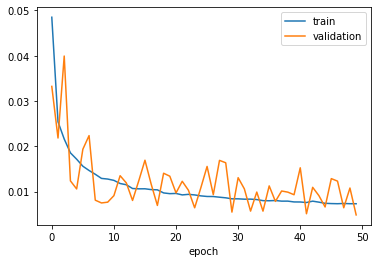

Elapsed 200.20285 s


In [9]:
tm = Timer()
NN_Train(Model,X_train,Y_train,50)
tm.timer()

As we can see from the evolution of the error, along the epochs the error decrease. Now we could try to predict using the predict method for the test set. We will us the display_result function which will predict the label from both the train and test dataset in order to compute the in sample (from train set) and out of sample (from test set) error and standard deviation. It will also display the error distribution and the mean absolute error for the test set.

@ InSample                : E[y-t]: 0.004568 Std(y-t): 0.004432
@
@ OutOfSample             : E[y-t]: 0.005050 Std(y-t): 0.004903
@


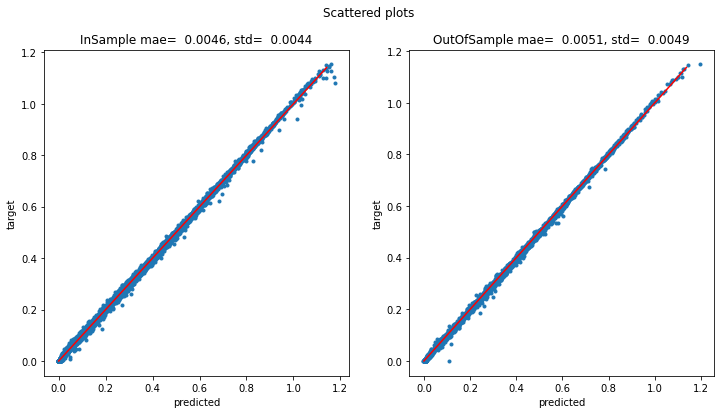

4071/4071 [==============================] - 1s 172us/step
loss = 0.000050 ; mae = 0.005050


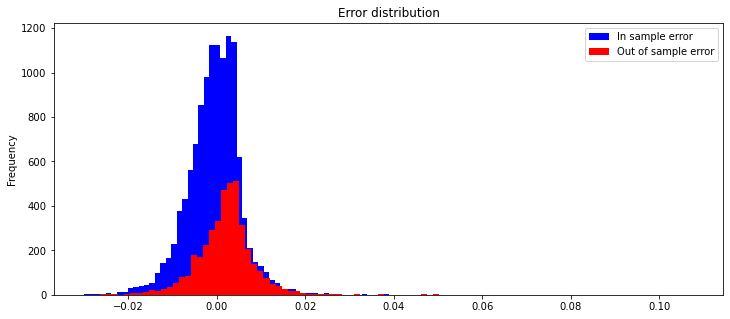

'\nresult for 2^17 sample size\n@ InSample                : E[y-t]: 0.003970 Std(y-t): 0.003169 \n@ OutOfSample             : E[y-t]: 0.004277 Std(y-t): 0.003505\n@'

In [10]:
display_nn_results(Model,X_train,X_test,Y_train,Y_test)
'''
result for 2^17 sample size
@ InSample                : E[y-t]: 0.003970 Std(y-t): 0.003169 
@ OutOfSample             : E[y-t]: 0.004277 Std(y-t): 0.003505
@'''

#

## Volatility Feature Approach
We will use a market generator that will consider as bounds only the time to maturity and the moneyness of the option, but once we compute the price of the option for constant model parameter and the bound parameter,it will compute the implied volatility for a given set of strike price. Through this method we simulate market condition  obtaining a volatility surface. Alternatively we can produce random parameter in order to build a more heterogeneus volatility surface.

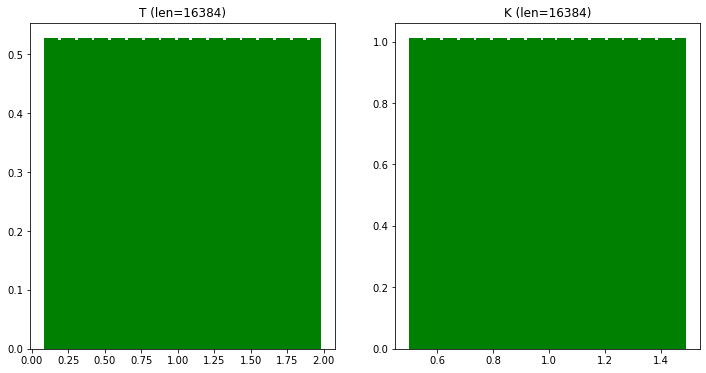

Elapsed 132.35500 s


,T,K,0.4,0.55,0.7000000000000001,0.8500000000000001,1.0,1.1500000000000001,1.3000000000000003,1.4500000000000002,1.6,P
0,0.436450,0.779327,0.618399,0.639885,0.674987,0.717663,0.764528,0.812118,0.857407,0.898472,0.934560,0.074260
1,0.667610,1.406891,0.647505,0.680025,0.716094,0.752851,0.788366,0.821334,0.851075,0.877422,0.900547,0.573560
2,1.677066,1.137970,0.737003,0.763211,0.784380,0.801884,0.816635,0.829274,0.840260,0.849932,0.858541,0.508299
3,0.406853,1.411224,0.615803,0.634008,0.668249,0.711425,0.760035,0.810292,0.858643,0.902690,0.941413,0.521744
4,0.553317,1.454193,0.632376,0.661551,0.698063,0.737990,0.778618,0.817698,0.853696,0.885870,0.914114,0.591539


In [19]:
def vol_model_generator(name:str,bound,Num,rand,xc,strikes):
    tim = Timer()

    if name == 'J_normal':
        model_parm = {'lmbda': 0.5, 'sigma': .5, 'm':0.5,'eta':0.5}
        data = lhs_sampling(rand, Num, bound)
        histo_dict(data)
        pricer = np.ndarray((Num,1))
        vol = np.ndarray((Num,len(strikes)))
        for i in range(Num):
            pricer[i] = ft_opt(
                jmp_normal(lmbda=model_parm['lmbda'],sigma=model_parm['sigma'],m=model_parm['m'],eta=model_parm['eta']),
                data['K'].tolist()[i],data['T'].tolist()[i], xc)['put']

            vol[i] = np.transpose(vectorized_implied_volatility([ft_opt(
                jmp_normal(lmbda=model_parm['lmbda'],sigma=model_parm['sigma'],m=model_parm['m'],eta=model_parm['eta']),
                k, data['T'].tolist()[i], xc)['put'] for k in strikes],1,strikes,data['T'].tolist()[i],0,'p'))
        for k in range(len(strikes)):
            data[str(strikes[k])] = vol[:,k]
        
        data['P'] = pricer
        tim.timer()
        return Num, data

    elif name == 'J_bin':
        model_parm = {'lmbda':0.5,'sigma':.5,'pi':0.5,'u':.5,'d':.5}

        data = lhs_sampling(rand, Num, bound)
        histo_dict(data)
        pricer = np.ndarray(Num)
        vol = np.ndarray((Num,len(strikes)))
        for i in range(Num):
            pricer[i] = ft_opt(jmp_binary(lmbda=model_parm['lmbda'],sigma=model_parm['sigma'],pi=model_parm['pi'],u=model_parm['u'],d=model_parm['d']),data['K'].tolist()[i],data['T'].tolist()[i], xc)['put']
            vol[i] = np.transpose(vectorized_implied_volatility([ft_opt(jmp_binary(lmbda=model_parm['lmbda'],sigma=model_parm['sigma'],pi=model_parm['pi'],u=model_parm['u'],d=model_parm['u']),
                                                                        k,data['T'].tolist()[i], xc)['put'] for k in strikes],1,strikes,data["T"].tolist()[i],0,'p'))
        for k in range(len(strikes)):
            data[str(strikes[k])] = vol[:,k]
        
        data['P'] = pricer
        tim.timer()
        return Num, data
    elif name == 'J_normal_parm':
        
        parm = lhs_sampling(rand, Num, bound)
        histo_dict(parm)
        data = pd.DataFrame()
        data['T'] = parm['T']
        data['K'] = parm['K']
        plt.show()
        pricer = np.ndarray((Num,1))
        vol = np.ndarray((Num,len(strikes)))
        for i in range(Num):
            pricer[i] = ft_opt(
                jmp_normal(lmbda=parm['lmbda'].tolist()[i],sigma=parm['sigma'].tolist()[i],m=parm['m'].tolist()[i],eta=parm['eta'].tolist()[i]),
                data['K'].tolist()[i],data['T'].tolist()[i], xc)['put']

            vol[i] = np.transpose(vectorized_implied_volatility([ft_opt(
                jmp_normal(lmbda=parm['lmbda'].tolist()[i],sigma=parm['sigma'].tolist()[i],m=parm['m'].tolist()[i],eta=parm['eta'].tolist()[i]),
                k, data['T'].tolist()[i], xc)['put'] for k in strikes],1,strikes,data['T'].tolist()[i],0,'p'))
        for k in range(len(strikes)):
            data[str(strikes[k])] = vol[:,k]
        
        data['P'] = pricer
        tim.timer()
        return Num, data

    elif name == 'J_bin_parm':
        bound = {'lmbda': [0.1, 1],
                 'sigma': [0.001, +0.2],
                 'pi':[0,1],
                 'u':[0,1],
                 'd':[0,1],
                 'T': [1 / 24, 2],
                 'K': [0.5, 1.5]
                 }
        

        parm = lhs_sampling(rand, Num, bound)
        histo_dict(parm)
        data = pd.DataFrame()
        data['T'] = parm['T']
        data['K'] = parm['K']
        pricer = np.ndarray(Num)
        vol = np.ndarray((Num,len(strikes)))
        for i in range(Num):
            pricer[i] = ft_opt(jmp_binary(lmbda=parm['lmbda'].tolist()[i],sigma=parm['sigma'].tolist()[i],pi=parm['pi'].tolist()[i],u=parm['u'].tolist()[i],d=parm['d'].tolist()[i]),data['K'].tolist()[i],data['T'].tolist()[i], xc)['put']
            vol[i] = np.transpose(vectorized_implied_volatility([ft_opt(jmp_binary(lmbda=model_parm['lmbda'],sigma=model_parm['sigma'],pi=model_parm['pi'],u=model_parm['u'],d=model_parm['u']),
                                                                        k,data['T'].tolist()[i], xc)['put'] for k in strikes],1,strikes,data["T"].tolist()[i],0,'p'))
        for k in range(len(strikes)):
            data[str(strikes[k])] = vol[:,k]
        
        data['P'] = pricer
        tim.timer()
        return Num, data
    else:
        tim.timer()
        pass



'''method = "J_normal_parm"
bound = {
                'lmbda': [0.1, 1],
                 'sigma': [0.001, +0.2],
                 'm':[0,1],
                 'eta':[0,1],
                 'T': [1 / 12, 2],
                 'K': [0.5, 1.5]
                 }'''

method = 'J_normal'
bound = {
        'T': [1 / 12, 2],
        'K': [0.5, 1.5]
        }


rand = np.random.RandomState(42)
strikes = np.linspace(0.4,1.6,9)
Num,data = vol_model_generator(method,bound,2**14,rand,10,strikes)
data.head()



To observe the volatility surface we first plot 16 volatililty smile across the time to maturity and then we try to plot the volatility surface itself.

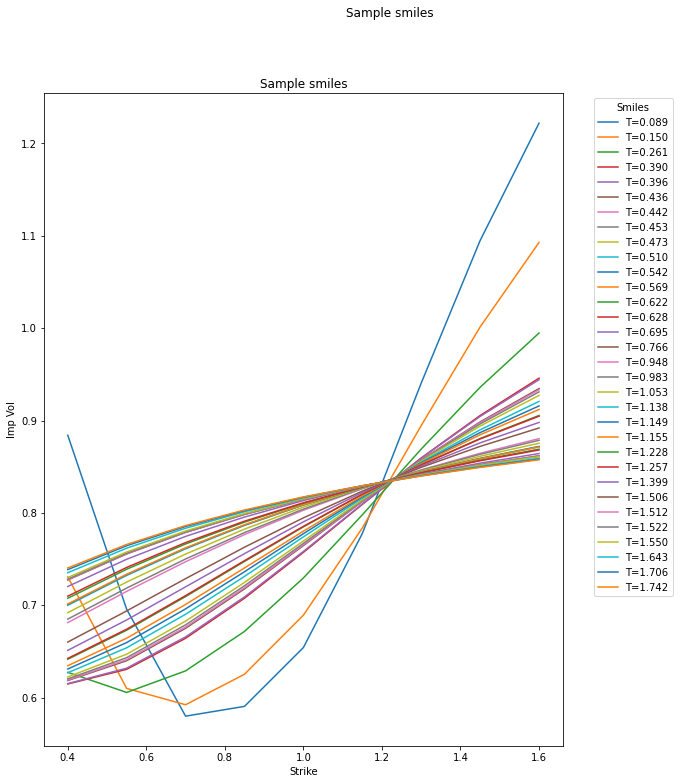

In [20]:
x = data['K'].to_numpy()
y = data['T'].to_numpy()
z = data.drop(['K','P','T'],axis=1).to_numpy()


smiles = smiles_select(strikes, data, NUMSMILES=32)
show_smiles(smiles=smiles)


<IPython.core.display.Javascript object>


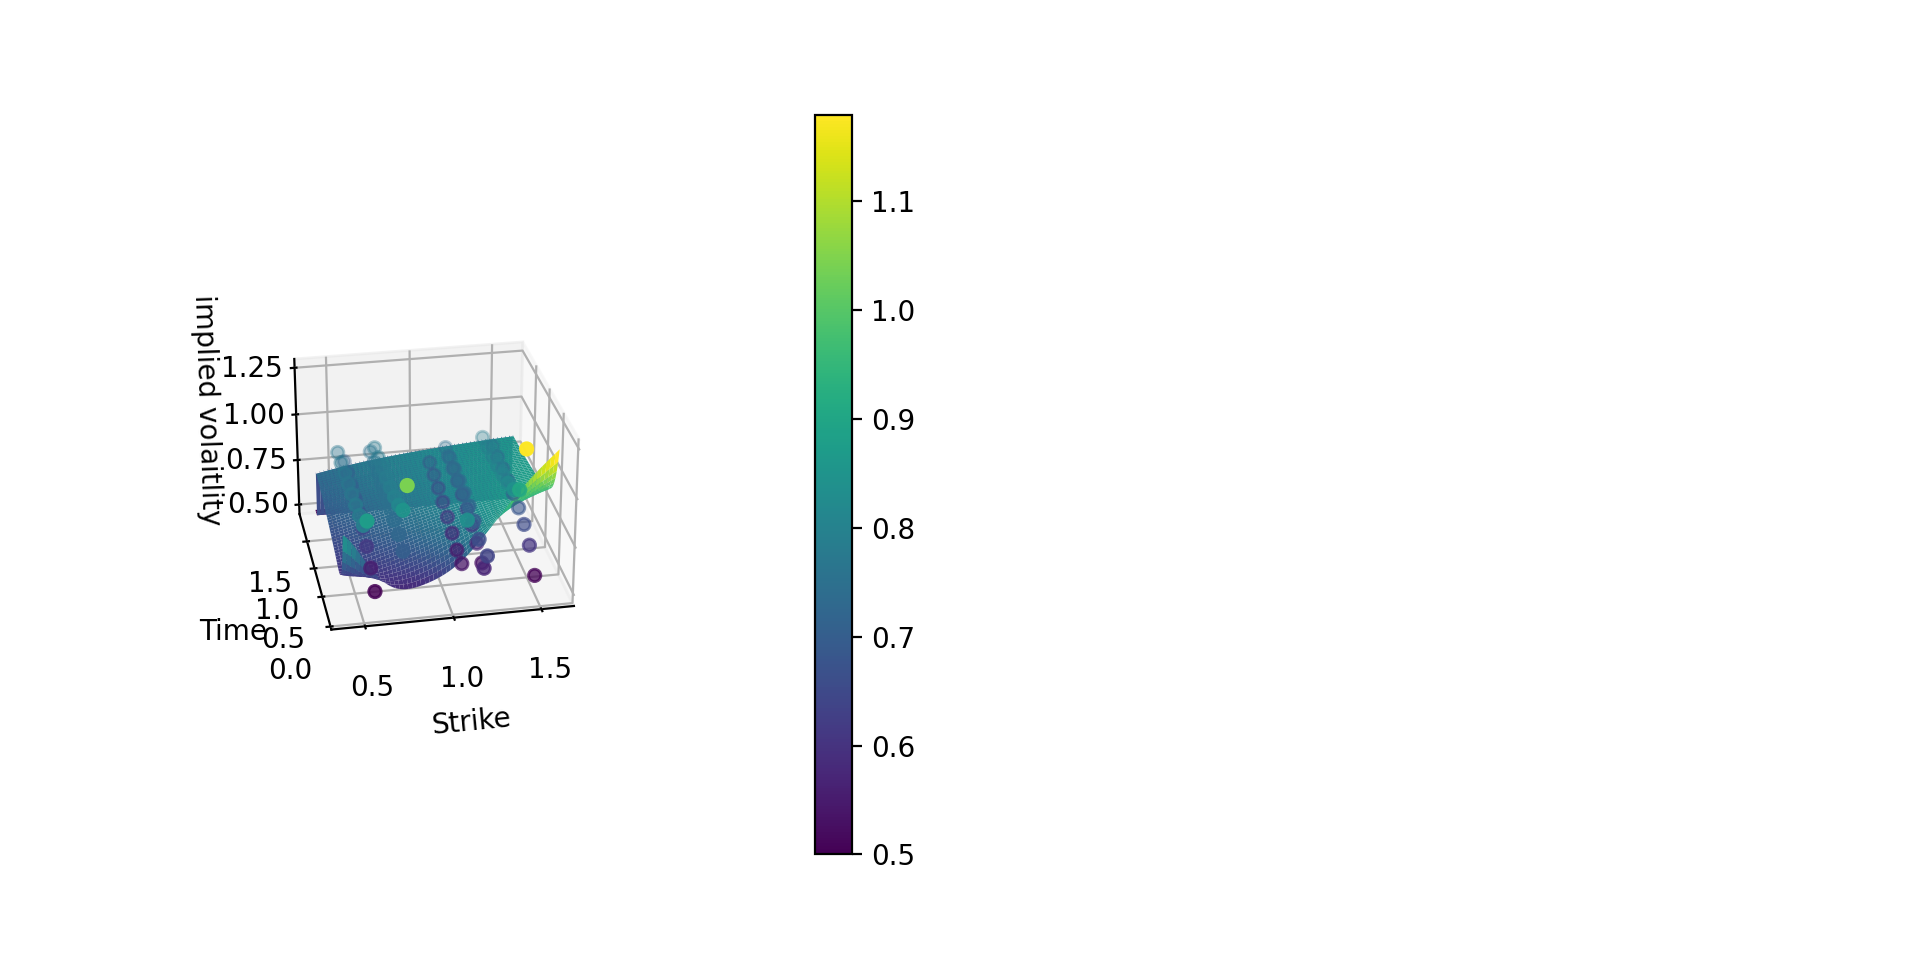

In [21]:
%matplotlib notebook
def surface(Data,strikes,Num):
    data = Data.sort_values('T')
    data = data.dropna()
    ix = [int(i*Num/len(strikes)) for i in range(len(strikes))]
    
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    Y = data['T'].to_numpy()[ix]
    X = data['K'].to_numpy()[ix]
    z = data.drop(['K','P','T'],axis=1).to_numpy()
    Z = np.ndarray((len(strikes),len(strikes)))
    
    for i in range(len(strikes)):
        for j in range(len(strikes)):
            Z[i,j] = z[ix[i],j]

    f = sp.interpolate.interp2d(strikes,Y,Z,kind='quintic',fill_value='.5')
    x = np.linspace(0.4,1.6,1000)
    y = np.linspace(1/11,1.9,1000)
    z = f(x,y)
    x,y = np.meshgrid(x,y)
    plot = ax.plot_surface(x,y,z,cmap='viridis')
    X,Y = np.meshgrid(X,Y)
    
    ax.view_init(elev=0)
    
    ax.scatter(X,Y,Z,c=Z,cmap='viridis')
    ax.set_ylabel("Time")
    ax.set_xlabel("Strike")
    ax.set_zlabel("implied volaitlity")
    fig.colorbar(plot,pad =0.3)
    plt.show()
    
    
    
surface(data,strikes,Num)



We used fifth degree interpolation to fit the volatility surface, other possible plot yield confusing information.

<IPython.core.display.Javascript object>


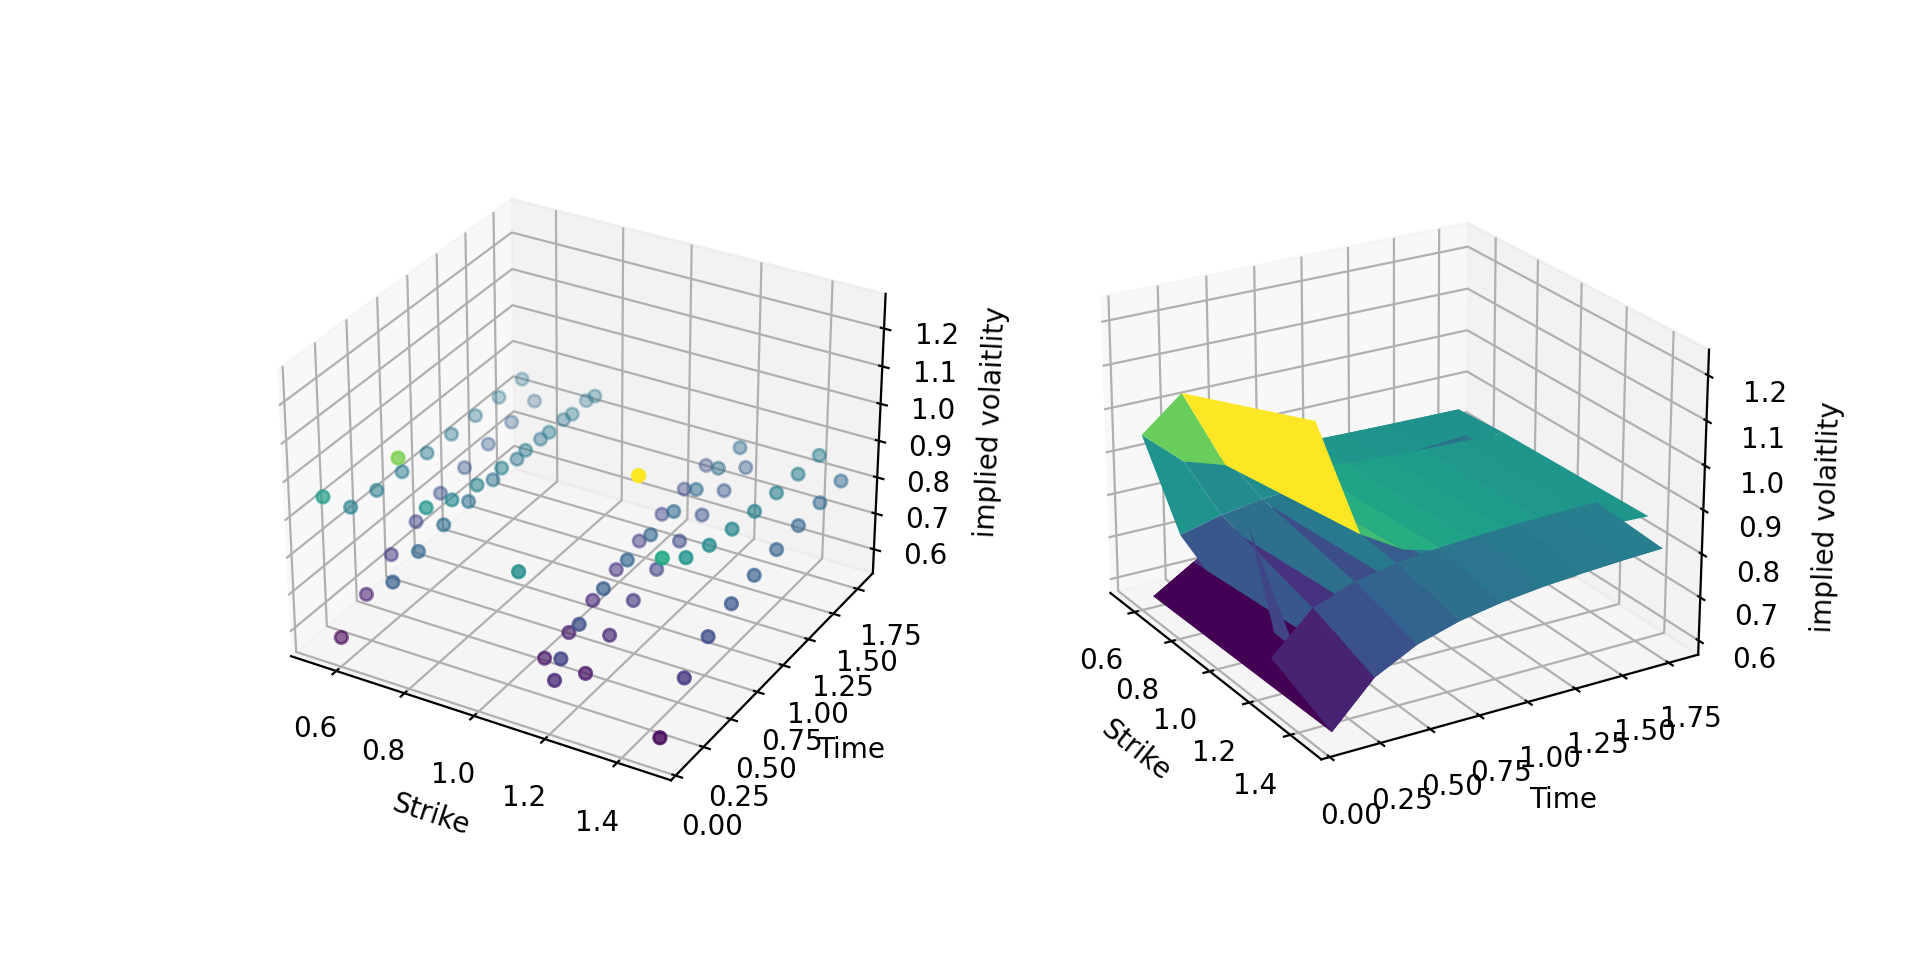

In [22]:
def surface(Data,strikes,Num):
    data = Data.sort_values('T')
    data = data.dropna()
    ix = [int(i*Num/len(strikes)) for i in range(len(strikes))]
    
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    Y = data['T'].to_numpy()[ix]
    X = data['K'].to_numpy()[ix]

    X,Y = np.meshgrid(X,Y)
    z = data.drop(['K','P','T'],axis=1).to_numpy()
    Z = np.ndarray((len(strikes),len(strikes)))
    
    for i in range(len(strikes)):
        for j in range(len(strikes)):
            Z[i,j] = z[ix[i],j]

    ax.scatter(X,Y,Z,c=Z,cmap='viridis')
    ax.set_ylabel("Time")
    ax.set_xlabel("Strike")
    ax.set_zlabel("implied volaitlity")

    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_surface(X,Y,Z,cmap='viridis')
    #ax.plot_wireframe(X,Y,Z)
    ax.set_ylabel("Time")
    ax.set_xlabel("Strike")
    ax.set_zlabel("implied volaitlity")
    plt.show()
    
surface(data,strikes,Num)

We used scipy to interpolate the implied volatility values with the coordinates of strike and maturity, since the simple plotting yield confusing shapes. Now we can proceed processing the data. 

In [23]:
X_train, X_test, Y_train, Y_test = preprocessing(data,seed=seed,scaling=True,size=.25,eps=0)                                  

             0         1         2         3         4         5         6   \
0     -0.334699  0.770131 -0.450361 -0.061673  0.109877  0.193818  0.253016   
1     -0.307187 -0.877600 -0.414801 -0.029596  0.135317  0.215136  0.270991   
2     -1.112242  0.800562 -1.535877 -1.293123 -1.004606 -0.849122 -0.721166   
3     -0.117775 -1.394299 -0.182391  0.174052  0.293399  0.345272  0.378789   
4     -1.429692 -1.447343 -1.243336 -1.917174 -1.802797 -1.759186 -1.708869   
...         ...       ...       ...       ...       ...       ...       ...   
12283  0.550565 -1.018134  0.474958  0.702373  0.677892  0.645426  0.613906   
12284 -0.632045 -1.143029 -0.861868 -0.454365 -0.214292 -0.087114  0.008301   
12285 -1.408952 -0.213394 -1.339026 -1.884085 -1.742356 -1.683492 -1.621723   
12286  1.369588 -1.351188  1.012875  1.092374  0.940934  0.838402  0.754594   
12287 -1.276046  1.015695 -1.607431 -1.628827 -1.383027 -1.258939 -1.150114   

             7         8         9         10  
0  

And building the model.

In [24]:
def NN_builder(inp_shape):      #input shape has value equal to the number of parameter that we will plug eg BS use 3 parameter, input shape=3
    mdl = Sequential(name="VFA_Option_%s_%d"%(method,Num))
    mdl.add(Dense(200, activation='relu', input_shape=inp_shape,name='Input_layer'))  #rectified linear unit activation function, 200 neuron for each layer and 1 neuron(price) for the output layer
    mdl.add(Dense(200, activation='relu',name="hidden_1"))
    mdl.add(Dense(200, activation='relu',name="hidden_2"))
    mdl.add(Dense(200, activation='relu',name="hidden_3"))
    mdl.add(Dense(1,name="Price_output"))
    mdl.summary()
    mdl.get_config()
    mdl.compile(loss='mse', optimizer='rmsprop', metrics=['mae']) #loss function used is the mean squared error (squred residual), bacward propagation is done thorough RSM prop and the analyzed metric is the mean absolute error
    return mdl

Model = NN_builder((X_train.shape[1],))

Model: "VFA_Option_J_normal_16384"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Dense)          (None, 200)               2400      
_________________________________________________________________
hidden_1 (Dense)             (None, 200)               40200     
_________________________________________________________________
hidden_2 (Dense)             (None, 200)               40200     
_________________________________________________________________
hidden_3 (Dense)             (None, 200)               40200     
_________________________________________________________________
Price_output (Dense)         (None, 1)                 201       
Total params: 123,201
Trainable params: 123,201
Non-trainable params: 0
_________________________________________________________________


Now we can proceed in training and observing the results.

Train on 8232 samples, validate on 4056 samples
Epoch 1/50
8232/8232 [==============================] - 3s 404us/step - loss: 5.2603e-05 - mae: 0.0047 - val_loss: 1.2678e-05 - val_mae: 0.0030
Epoch 2/50
8232/8232 [==============================] - 3s 401us/step - loss: 5.3500e-05 - mae: 0.0048 - val_loss: 3.6605e-05 - val_mae: 0.0050
Epoch 3/50
8232/8232 [==============================] - 3s 397us/step - loss: 5.2060e-05 - mae: 0.0050 - val_loss: 6.3652e-05 - val_mae: 0.0065
Epoch 4/50
8232/8232 [==============================] - 3s 406us/step - loss: 5.2407e-05 - mae: 0.0047 - val_loss: 4.3295e-06 - val_mae: 0.0013
Epoch 5/50
8232/8232 [==============================] - 3s 405us/step - loss: 5.0591e-05 - mae: 0.0047 - val_loss: 3.9043e-05 - val_mae: 0.0051
Epoch 6/50
8232/8232 [==============================] - 3s 409us/step - loss: 5.1108e-05 - mae: 0.0047 - val_loss: 4.0865e-05 - val_mae: 0.0045
Epoch 7/50
8232/8232 [==============================] - 3s 411us/step - loss: 5.0272e-05

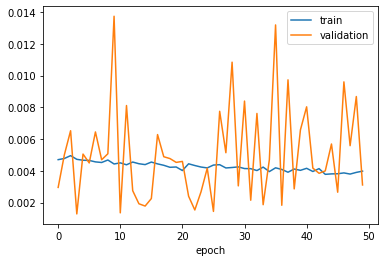

In [27]:
%matplotlib inline
NN_Train(Model,X_train,Y_train,50)

@ InSample                : E[y-t]: 0.001806 Std(y-t): 0.001513
@
@ OutOfSample             : E[y-t]: 0.002519 Std(y-t): 0.002038
@


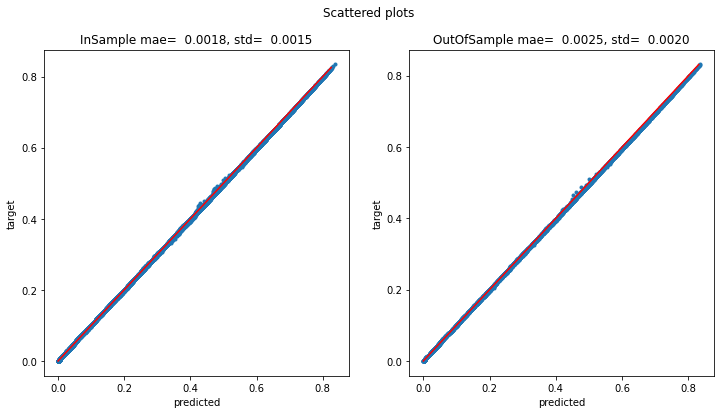

4096/4096 [==============================] - 0s 79us/step
loss = 0.000010 ; mae = 0.002519


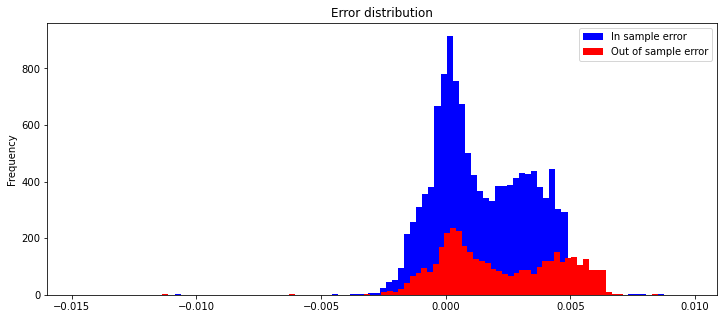

In [26]:
display_nn_results(Model,X_train,X_test,Y_train,Y_test)

### Note on the scripts
#### Volatility surface plot
The script used to plot the volatility surface (not interpolation) consider a sample of the initial dataset. Since we are considering 9 different strike, we shall use only 9 value for time to maturity and strikes, and hence a 9x9 volatility matrix. To sample the time to maturity, the dataset is sorted on such column and then rows are extracted at the equivalent percentile, in this way we obtain a uniform surface across different maturities.
#### RMSProp
Gradient descent algorithm are used to minimize the loss function. In general it work by modifying the weights of the model in the opposite direction of the gradient by a specified learning rate/step. The RMSprop is an adaptive learning rate algorithm, it compute an exponential average of the squared past gradient and then divide the fixed learning rate by such exponential average.
#### Save and load model
Follow the script used to save and load an existing model. It is based on the package h5py in order to save the model as an .hdf5 format.

In [ ]:
from tensorflow.keras.models import  load_model

def save_mdl(Model):
    name = Model.name+"_size_"+str(Num)+".h5"
    Model.save(name)

def load_mdl(name):
    Model = load_model(name)
    Model.summary()
    return Model

#save_mdl(Model)
#load_mdl("VFA_Option_J_normal_size_4096.h5")